## Imports Required

In [1]:
import pickle
from os.path import exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Solver Class

In [2]:
class FlightTicketPriceOptimizer:
    def __init__(self, param = None):
        self.parameter_template = {
            "price_coach_low": { "dtype": float, "prompt": "Coach lower ticket price"},
            "price_coach_high": { "dtype": float, "prompt": "Coach higher ticket price"},
            "price_fclass_low": { "dtype": float, "prompt": "First class lower ticket price"},
            "price_fclass_high": { "dtype": float, "prompt": "First class lower ticket price"},
            "booking_proba_coach_lowpr": { "dtype": float, "prompt": "Probability of booking for coach at lower price"},
            "booking_proba_coach_highpr": { "dtype": float, "prompt": "Probability of booking for coach at higher price"},
            "booking_proba_fclass_lowpr": { "dtype": float, "prompt": "Probability of booking for first class at lower price"},
            "booking_proba_fclass_highpr": { "dtype": float, "prompt": "Probability of booking for first class at higher price"},
            "prob_change_on_fclass_sold": { "dtype": float, "prompt": "Change in coach probability when first class is sold out"},
            "cost_of_bumping": { "dtype": float, "prompt": "Cost of bumping passenger to first class"},
            "cost_of_stipend": { "dtype": float, "prompt": "Cost of bumping passenger off the plane"},
            "discount": { "dtype": float, "prompt": "Annual Discount rate (as decimal)"},
            "proba_coach_showing_up": { "dtype": float, "prompt": "Probability of coach passenger showing up"},
            "proba_fclass_showing_up": { "dtype": float, "prompt": "Probability of first class passenger showing up"},
            "n_seats_coach": { "dtype": int, "prompt": "Number of seats in coach"},
            "n_seats_fclass": { "dtype": int, "prompt": "Number of seats in first class"},
            "overbook_limit": { "dtype": int, "prompt": "Allowed overbooking limit"},
            "days_left": { "dtype": int, "prompt": "Days left until departure"},
            "block_bookings": { "dtype": int, "prompt": "Enable booking blocker option? (1 for Yes, 0 for No)"},
        }

        self.solved = False
        self.U = None
        self.V = None

        if type(param) != type(None):
            self.set_parameters(param)

    def get_parameter_template(self):
        """
        Returns a parameter template that the user has to replace with the parameter values and `set_parameters` for the problem
        """
        return self.parameter_template
    
    def set_parameters(self, param: dict):
        """
        A function that sets (and calculates) any initial parameters required for solving the ticket pricing problem

        param: Parameters required (having the same structure as of the parameter template) for the problem
        """

        # Verify the structure matches the template
        for key in param.keys():
            assert key in self.parameter_template.keys()

        for key in self.parameter_template.keys():
            assert key in param.keys()
        
        # Set all class variable values that the user has provided as parameters
        for key in param.keys():
            setattr(self, key, param[key])

        # Calculate other values required for solving the problem
        self.price_coach = [self.price_coach_low, self.price_coach_high]
        self.price_fclass = [self.price_fclass_low, self.price_fclass_high]

        self.prob_coach = [self.booking_proba_coach_lowpr, self.booking_proba_coach_highpr]
        self.prob_fclass = [self.booking_proba_fclass_lowpr, self.booking_proba_fclass_highpr]
        self.prob_coach_fsold = [x + self.prob_change_on_fclass_sold for x in self.prob_coach]
        
        self.delta = 1/(1+(self.discount/365))
        self.seats_coach_eff = self.n_seats_coach + self.overbook_limit

        self.s1N = self.n_seats_fclass+1
        self.s2N = self.seats_coach_eff+1
        self.tN = self.days_left+1

        # Initialize the values of V and U arrays with their default values
        self.V = np.zeros((self.s1N, self.s2N, self.tN))
        self.U = np.array([[['#000000AA']*self.tN]*self.s2N]*self.s1N)

    def calculate_initial_conditions(self):
        """
        Calculate the initial conditions for V by calculating the expected costs from the overbooking for the day of departure
        """
        for s1 in range(self.s1N):
            for s2 in range(self.s2N):
                self.V[s1, s2, self.tN-1] = -self.__expected_cost__(self.n_seats_fclass-s1, self.seats_coach_eff-s2)

    def calculate_values(self):
        """
        Backtrack from the final day to the initial day and calculate the value functions,
            and corresponding `best actions` to take encoded as a hex color (for the purpose of plotting)
        """
        
        for t in reversed(range(self.tN-1)):
            for s1 in range(self.s1N):
                for s2 in range(self.s2N):
                    if s1 == 0 and s2 == 0:
                        self.V[s1, s2, t] = self.delta*self.V[s1, s2, t+1]
                    else:
                        # Set effective probabilities of sale as 0 if the tickets are sold out for the particular class or
                        #   set the effective probability of sale for the coach class to the higher value if first class is sold out
                        #   ** Add an extra 0 at the end of coach probabilities to consider the case of "blocking" a sale by forcing demand to 0
                        prob_coach_eff = self.prob_coach if s1 != 0 else self.prob_coach_fsold
                        prob_fclass_eff = self.prob_fclass if s1 != 0 else [0, 0]
                        prob_coach_eff = prob_coach_eff + [0] if s2 != 0 else [0, 0, 0]
                        
                        # 6 possible decisions can be made at each time period
                        #   giving us 6 possible value functions if those decisions are made
                        # values[0] -> Sell Coach at High price,  Fclass High price     [x1, x2] --> [1, 1]
                        # values[1] -> Sell Coach at High price,  Fclass Low price      [x1, x2] --> [1, 0]
                        # values[2] -> Sell Coach at Low price,   Fclass High price     [x1, x2] --> [0, 1]
                        # values[3] -> Sell Coach at Low price,   Fclass Low price      [x1, x2] --> [0, 0]
                        # values[4] -> Block the sale of Coach,   Fclass High price     [x1, x2] --> [2, 1]    -- If block_bookings is 1
                        # values[5] -> Block the sale of Coach,   Fclass Low price      [x1, x2] --> [2, 0]    -- If block_bookings is 1

                        values = list()
                        for x1 in range(1,-1-self.block_bookings,-1):
                            for x2 in range(1,-1,-1):
                                value = self.price_coach[x1]*prob_coach_eff[x1] + self.price_fclass[x2]*prob_fclass_eff[x2] + self.delta*(
                                    prob_coach_eff[x1]*prob_fclass_eff[x2]*self.V[max(s1-1, 0), max(s2-1,0), t+1] + \
                                    prob_coach_eff[x1]*(1-prob_fclass_eff[x2])*self.V[s1, max(s2-1,0), t+1] + \
                                    (1-prob_coach_eff[x1])*prob_fclass_eff[x2]*self.V[max(s1-1, 0), s2, t+1] + \
                                    (1-prob_coach_eff[x1])*(1-prob_fclass_eff[x2])*self.V[s1, s2, t+1]
                                )
                                values.append(value)

                        # Choose the best value function
                        self.V[s1, s2, t] = max(values)

                        # Choose the decision that gives the best value function
                        tmp = np.argmax(values)
                        rgb = [0,0,0]
                        
                        if s1:  # Set the green pixel intensity based on Fclass price - 255 for high price, 127 for low price
                            rgb[1] = ((int(tmp == 0 or tmp == 2 or tmp == 4) + 1)*128)-1
                        
                        if s2:  # Set the blue (Red if sale is blocked) pixel intensity based on coach price - 255 for high price, 127 for low price
                            rgb[2] = ((int(tmp == 0 or tmp == 1) + 1)*128)-1
                            rgb[0] = int(tmp == 4 or tmp == 5)*127

                        self.U[s1, s2, t] = self.__rgb_to_hex__(tuple(rgb))
        self.solved = True

    def get_solution(self):
        """
        Returns the value function matrix `V`, and the optimal decision matrix `U` [If the problem has been solved]
        """
        assert self.solved
        return self.V, self.U
    
    def __cost_if__(self, fclass_show, coach_show):
        """
        Calculate the cost if exactly
        
        fclass_show:    number of people show up for the first class
        coach_show:     number of people show up for the Coach class
        """
        cost = 0
        f_class_free_seats = self.n_seats_fclass - fclass_show
        assert f_class_free_seats >= 0

        stipend_customers = max(0, coach_show - self.n_seats_coach)
        assert stipend_customers >= 0

        if stipend_customers == 0:
            return 0
        if stipend_customers < f_class_free_seats:
            return stipend_customers*self.cost_of_bumping
        return f_class_free_seats*self.cost_of_bumping + (stipend_customers-f_class_free_seats)*self.cost_of_stipend

    def __expected_cost__(self, fclass_booked, coach_booked):
        """
        Calculate the expected cost if

        fclass_booked:  number of people have booked the First class ticket
        coach_booked:   number of people have booked the Coach ticket
        """
        cost = 0
        bin_prob_fclass = binom(fclass_booked, self.proba_fclass_showing_up)
        bin_prob_coach = binom(coach_booked, self.proba_coach_showing_up)
        for f in range(fclass_booked+1):
            for c in range(coach_booked+1):
                cost += bin_prob_coach.pmf(c)*bin_prob_fclass.pmf(f)*self.__cost_if__(f, c)
        return cost
    
    def __rgb_to_hex__(self, rgb):
        """
        Calculate the hexcode given the RGB tuple and return the hexcode (at 50% opacity)
        
        rgb: the RGB tuple with values ranging from 0 to 255
        """
        return '#%02x%02x%02xAA' % rgb
    
    def plot_decisions(self):
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca(projection='3d', adjustable='box')
        ax.set_xlabel("FC_sold")
        ax.set_ylabel("Coach_sold")
        ax.set_zlabel("Time")
        ax.grid(False)
        ax.voxels(np.ones(self.U.shape), facecolors=self.U, shade=False)
        ax.set_box_aspect([1,1,1])
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        origin = np.mean(limits, axis=1)
        radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
        x, y, z = origin
        ax.set_xlim3d([x - radius, x + radius])
        ax.set_ylim3d([y - radius, y + radius])
        ax.set_zlim3d([z - radius, z + radius])
        plt.show()
        
    def simulate_day(self, fc_state, coach_state, t):
        fc_price, fc_prob, coach_price, coach_prob = self.make_decision(fc_state, coach_state, t)

        # Simulate a sale/no-sale
        fc_sale = int(np.random.random(1) < fc_prob)
        coach_sale = int(np.random.random(1) < coach_prob)

        # Calculate the profit/cost
        if t == self.tN-1:
            fc_shows = np.random.binomial(self.n_seats_fclass-fc_state, self.proba_fclass_showing_up)
            coach_shows = np.random.binomial(self.seats_coach_eff-coach_state, self.proba_coach_showing_up)
            discounted_val_today = -self.__cost_if__(fc_shows, coach_shows)*(self.delta**t)
        else:
            rev_today = fc_sale*fc_price + coach_sale*coach_price
            discounted_val_today = rev_today*(self.delta**t)

        return fc_price, fc_sale, coach_price, coach_sale, discounted_val_today
    
    def make_decision(self, fc_state, coach_state, t):
        color = self.U[fc_state, coach_state, t]

        prob_coach_eff = self.prob_coach if fc_state != 0 else self.prob_coach_fsold
        prob_fclass_eff = self.prob_fclass
        
        fc_idx = None
        coach_idx = None
        
        # Set coach probability and price
        if color[5:7] == 'ff':     # Sell Coach at High price
            coach_idx = 1
        elif color[5:7] == '7f':   # Sell Coach at Low price
            coach_idx = 0
        elif color[5:7] == '00':   # Sold out of Coach seats
            coach_idx = -1
        if color[1:3] == '7f':     # Override to set `No Sale` **
            coach_idx = -1
        
        # Set First class probability and price
        if color[3:5] == 'ff':     # Sell first class at High price
            fc_idx = 1
        elif color[3:5] == '7f':   # Sell first class at High price
            fc_idx = 0
        elif color[3:5] == '00':   # Sold out of First class seats
            fc_idx = -1

        assert type(fc_idx) != type(None) and type(coach_idx) != type(None)
        return  0 if fc_idx == -1 else self.price_fclass[fc_idx], \
                0 if fc_idx == -1 else prob_fclass_eff[fc_idx], \
                0 if coach_idx == -1 else self.price_coach[coach_idx], \
                0 if coach_idx == -1 else prob_coach_eff[coach_idx]

## Part-1

In [3]:
# Option 1: Create an empty object FlightTicketPriceOptimizer and get user input (from console) for each parameter
ft = FlightTicketPriceOptimizer()

param_template = ft.get_parameter_template()
for param in param_template.keys():
    ip = input(f"{param_template[param]['prompt']}:\t")
    ip = param_template[param]['dtype'](ip)
    param_template[param] = ip

ft.set_parameters(param_template)

Coach lower ticket price:	 300
Coach higher ticket price:	 325
First class lower ticket price:	 425
First class lower ticket price:	 500
Probability of booking for coach at lower price:	 0.65
Probability of booking for coach at higher price:	 0.30
Probability of booking for first class at lower price:	 0.08
Probability of booking for first class at higher price:	 0.04
Change in coach probability when first class is sold out:	 0.03
Cost of bumping passenger to first class:	 50
Cost of bumping passenger off the plane:	 425
Annual Discount rate (as decimal):	 0.17
Probability of coach passenger showing up:	 0.95
Probability of first class passenger showing up:	 0.97
Number of seats in coach:	 100
Number of seats in first class:	 20
Allowed overbooking limit:	 5
Days left until departure:	 365
Enable booking blocker option? (1 for Yes, 0 for No):	 0


In [4]:
# Option 2: Create an object FlightTicketPriceOptimizer by passing the parameters if the dictionary structure is already known
ft = FlightTicketPriceOptimizer({'price_coach_low': 300.0,
    'price_coach_high': 350.0,
    'price_fclass_low': 425.0,
    'price_fclass_high': 500.0,
    'booking_proba_coach_lowpr': 0.65,
    'booking_proba_coach_highpr': 0.3,
    'booking_proba_fclass_lowpr': 0.08,
    'booking_proba_fclass_highpr': 0.04,
    'prob_change_on_fclass_sold': 0.03,
    'cost_of_bumping': 50.0,
    'cost_of_stipend': 425.0,
    'discount': 0.17,
    'proba_coach_showing_up': 0.95,
    'proba_fclass_showing_up': 0.97,
    'n_seats_coach': 100,
    'n_seats_fclass': 20,
    'overbook_limit': 5,
    'days_left': 365,
    'block_bookings': 0
})

In [5]:
ft.calculate_initial_conditions()
ft.calculate_values()

In [6]:
ft.V[-1, -1, 0]

41886.158624195894

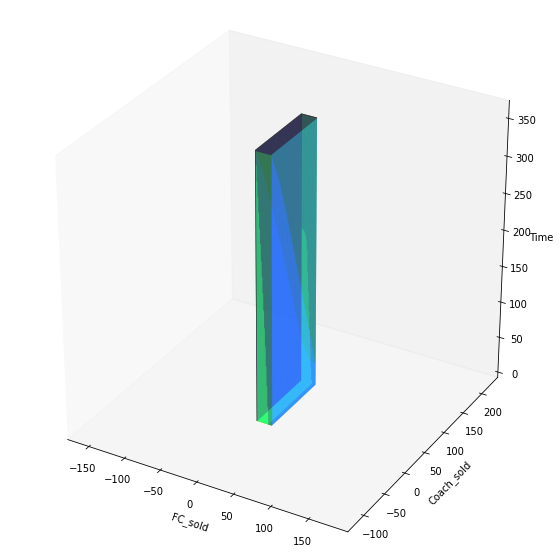

In [7]:
ft.plot_decisions()

## Part-2

In [8]:
csv_filepath = "max_expected_profit.csv"
obj_filepath = "flight_ticket_objects.pkl"

if exists(csv_filepath) and exists(obj_filepath):
    # Read solutions for Part-2
    df = pd.read_csv(csv_filepath)
    
    # Read solution objects for Part-2 (Reuse for Part-3)
    with open(obj_filepath, 'rb') as inp:
        ft_objs = pickle.load(inp)
else:
    exp_profit = list()
    ft_objs = list()
    for i in range(0, 21):
        ft = FlightTicketPriceOptimizer({'price_coach_low': 300.0,
            'price_coach_high': 350.0,
            'price_fclass_low': 425.0,
            'price_fclass_high': 500.0,
            'booking_proba_coach_lowpr': 0.65,
            'booking_proba_coach_highpr': 0.3,
            'booking_proba_fclass_lowpr': 0.08,
            'booking_proba_fclass_highpr': 0.04,
            'prob_change_on_fclass_sold': 0.03,
            'cost_of_bumping': 50.0,
            'cost_of_stipend': 425.0,
            'discount': 0.17,
            'proba_coach_showing_up': 0.95,
            'proba_fclass_showing_up': 0.97,
            'n_seats_coach': 100,
            'n_seats_fclass': 20,
            'overbook_limit': i,
            'days_left': 365,
            'block_bookings': 0
        })

        ft.calculate_initial_conditions()
        ft.calculate_values()

        exp_profit.append([i, ft.V[-1, -1, 0]])
        ft_objs.append(ft)

    df = pd.DataFrame(exp_profit, columns=["Overbooking", "Max_expected_profit"])
    df.to_csv(csv_filepath, index=False)
    with open(obj_filepath, 'wb') as outp:
        pickle.dump(ft_objs, outp, pickle.HIGHEST_PROTOCOL)

df

,Overbooking,Max_expected_profit
0,0,40654.294288
1,1,40942.071301
2,2,41221.454999
3,3,41481.575929
4,4,41707.623301
5,5,41886.158624
6,6,42011.221060
7,7,42085.536156
8,8,42122.167269
9,9,42134.624830


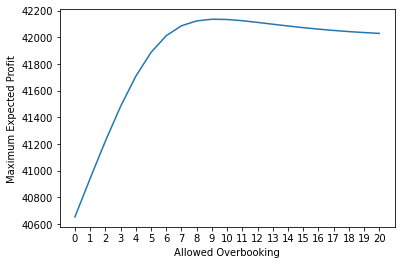

In [9]:
df.plot(kind='line', x='Overbooking', y='Max_expected_profit', legend=None)
plt.ylabel('Maximum Expected Profit')
plt.xlabel('Allowed Overbooking')
plt.xticks(df.index.values)
plt.show()

In [10]:
df.iloc[[df['Max_expected_profit'].idxmax()]]

,Overbooking,Max_expected_profit
9,9,42134.62483


## Part-3

In [11]:
csv_filepath2 = "max_expected_profit_blocking.csv"

if exists(csv_filepath2):
    # Read solutions for Part-3
    df2 = pd.read_csv(csv_filepath2)
else:
    exp_profit_blocking = list()
    for idx, obj in enumerate(ft_objs):
        obj.block_bookings = 1
        obj.calculate_values()

        exp_profit_blocking.append([idx, obj.V[-1, -1, 0]])

    df2 = pd.DataFrame(exp_profit_blocking, columns=["Overbooking", "Max_expected_profit"])
    df2.to_csv(csv_filepath2, index=False)

df2

,Overbooking,Max_expected_profit
0,0,40654.294288
1,1,40942.071301
2,2,41221.454999
3,3,41481.575929
4,4,41707.623301
5,5,41886.158624
6,6,42011.221060
7,7,42085.536156
8,8,42122.167269
9,9,42134.624830


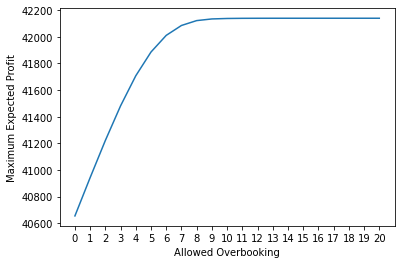

In [12]:
df2.plot(kind='line', x='Overbooking', y='Max_expected_profit', legend=None)
plt.ylabel('Maximum Expected Profit')
plt.xlabel('Allowed Overbooking')
plt.xticks(df2.index.values)
plt.show()

In [13]:
df2.iloc[[df2['Max_expected_profit'].idxmax()]]

,Overbooking,Max_expected_profit
20,20,42139.892762


## Part-4

### Without Sale blocking

In [3]:
optim_ft_1 = FlightTicketPriceOptimizer({'price_coach_low': 300.0,
    'price_coach_high': 350.0,
    'price_fclass_low': 425.0,
    'price_fclass_high': 500.0,
    'booking_proba_coach_lowpr': 0.65,
    'booking_proba_coach_highpr': 0.3,
    'booking_proba_fclass_lowpr': 0.08,
    'booking_proba_fclass_highpr': 0.04,
    'prob_change_on_fclass_sold': 0.03,
    'cost_of_bumping': 50.0,
    'cost_of_stipend': 425.0,
    'discount': 0.17,
    'proba_coach_showing_up': 0.95,
    'proba_fclass_showing_up': 0.97,
    'n_seats_coach': 100,
    'n_seats_fclass': 20,
    'overbook_limit': 9,
    'days_left': 365,
    'block_bookings': 0
})

In [4]:
optim_ft_1.calculate_initial_conditions()
optim_ft_1.calculate_values()

In [5]:
optim_ft_1.simulate_day(0,0,365)

(0, 0, 0, 0, -358.5717378777274)

In [6]:
optim_ft_1.tN

366

In [7]:
fc_seats = optim_ft_1.s1N-1
coach_seats = optim_ft_1.s2N-1
fc_seat_vec = list()
coach_seat_vec = list()
val_vec = list()
total_val = 0

for t in range(optim_ft_1.tN):
    fc_price, fc_sale, coach_price, coach_sale, discounted_val_today = optim_ft_1.simulate_day(fc_seats, coach_seats, t)
    
    # Update the states, and store results of the simulated day
    fc_seats -= fc_sale
    coach_seats -= coach_sale
    total_val += discounted_val_today
    
    fc_seat_vec.append(fc_seats)
    coach_seat_vec.append(coach_seats)
    val_vec.append(total_val)

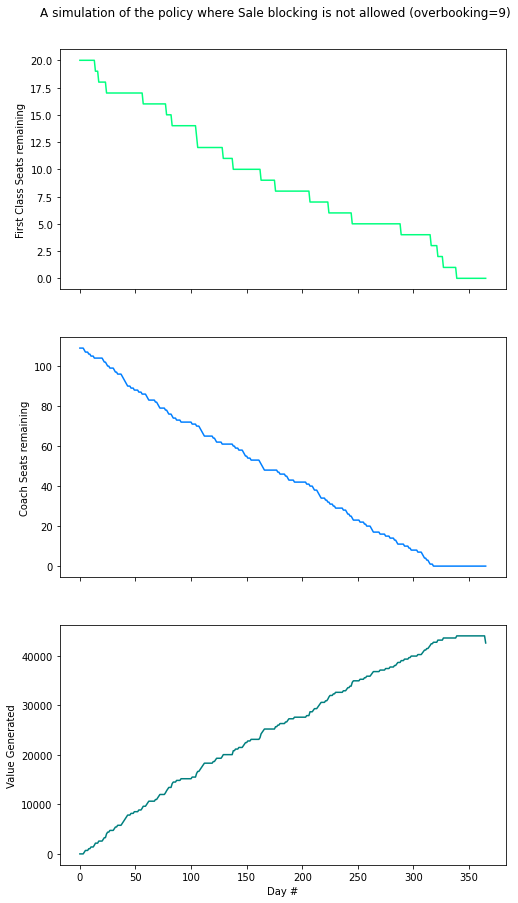

In [8]:
df_plot_1 = pd.DataFrame(np.array([range(optim_ft_1.tN), fc_seat_vec, coach_seat_vec, val_vec]).T, columns=["Day", "fc_seats_remaining", "coach_seats_remaining", "value"])
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8, 15))

plt.suptitle('A simulation of the policy where Sale blocking is not allowed (overbooking=9)', y=0.92)

df_plot_1.plot(ax=ax1, kind='line', x='Day', y='fc_seats_remaining', color="#00ff7f", legend=None)
ax1.set_ylabel('First Class Seats remaining')

df_plot_1.plot(ax=ax2, kind='line', x='Day', y='coach_seats_remaining', color="#007fff", legend=None)
ax2.set_ylabel('Coach Seats remaining')

df_plot_1.plot(ax=ax3, kind='line', x='Day', y='value', color="#007f7f", legend=None)
ax3.set_ylabel('Value Generated')
ax3.set_xlabel('Day #')
plt.show()

In [12]:
total_vals_1 = list()
costs = list()
for i in range(20000):
    total_val = 0
    fc_seats = optim_ft_1.s1N-1
    coach_seats = optim_ft_1.s2N-1
    
    for t in range(optim_ft_1.tN):
        fc_price, fc_sale, coach_price, coach_sale, discounted_val_today = optim_ft_1.simulate_day(fc_seats, coach_seats, t)
        
        # Update the states
        fc_seats = fc_seats - fc_sale
        coach_seats -= coach_sale
        total_val += discounted_val_today
    total_vals_1.append(total_val)
total_vals_1 = pd.Series(total_vals_1)

<AxesSubplot:>

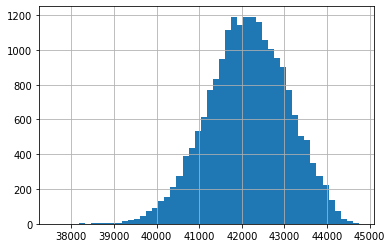

In [13]:
total_vals_1.hist(bins=50)

In [14]:
total_vals_1.describe()

count    20000.000000
mean     42139.331064
std        931.837130
min      37611.230876
25%      41520.236449
50%      42151.219232
75%      42802.076914
max      44749.819391
dtype: float64

### With Sale blocking

In [15]:
optim_ft_2 = FlightTicketPriceOptimizer({'price_coach_low': 300.0,
    'price_coach_high': 350.0,
    'price_fclass_low': 425.0,
    'price_fclass_high': 500.0,
    'booking_proba_coach_lowpr': 0.65,
    'booking_proba_coach_highpr': 0.3,
    'booking_proba_fclass_lowpr': 0.08,
    'booking_proba_fclass_highpr': 0.04,
    'prob_change_on_fclass_sold': 0.03,
    'cost_of_bumping': 50.0,
    'cost_of_stipend': 425.0,
    'discount': 0.17,
    'proba_coach_showing_up': 0.95,
    'proba_fclass_showing_up': 0.97,
    'n_seats_coach': 100,
    'n_seats_fclass': 20,
    'overbook_limit': 20,
    'days_left': 365,
    'block_bookings': 1
})

In [16]:
optim_ft_2.calculate_initial_conditions()
optim_ft_2.calculate_values()

In [17]:
fc_seats = optim_ft_2.s1N-1
coach_seats = optim_ft_2.s2N-1
fc_seat_vec = list()
coach_seat_vec = list()
val_vec = list()
total_val = 0

for t in range(optim_ft_2.tN):
    fc_price, fc_sale, coach_price, coach_sale, discounted_val_today = optim_ft_2.simulate_day(fc_seats, coach_seats, t)

    # Update the states, and store results of the simulated day
    fc_seats = fc_seats - fc_sale
    coach_seats -= coach_sale
    total_val += discounted_val_today
    
    fc_seat_vec.append(fc_seats)
    coach_seat_vec.append(coach_seats)
    val_vec.append(total_val)

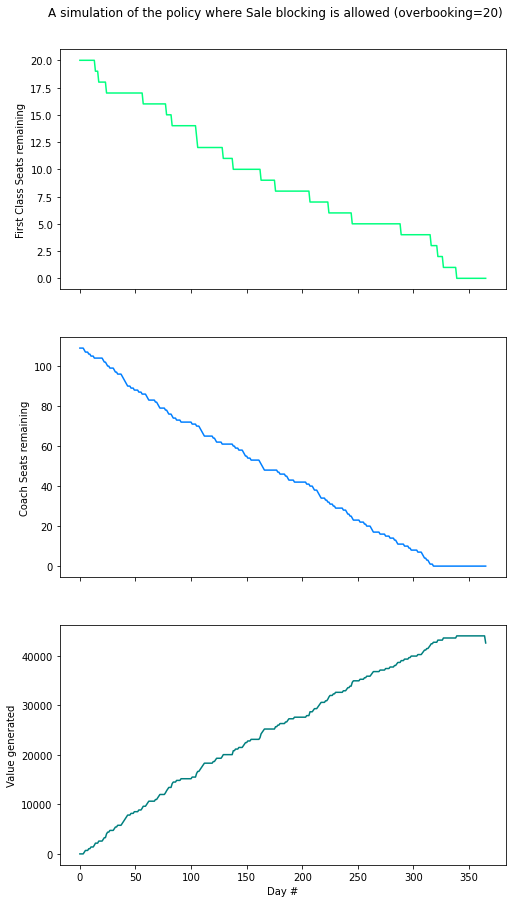

In [18]:
df_plot_2 = pd.DataFrame(np.array([range(optim_ft_2.tN), fc_seat_vec, coach_seat_vec, val_vec]).T, columns=["Day", "fc_seats_remaining", "coach_seats_remaining", "value"])
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8, 15))

plt.suptitle('A simulation of the policy where Sale blocking is allowed (overbooking=20)', y=0.92)

df_plot_1.plot(ax=ax1, kind='line', x='Day', y='fc_seats_remaining', color="#00ff7f", legend=None)
ax1.set_ylabel('First Class Seats remaining')

df_plot_1.plot(ax=ax2, kind='line', x='Day', y='coach_seats_remaining', color="#007fff", legend=None)
ax2.set_ylabel('Coach Seats remaining')

df_plot_1.plot(ax=ax3, kind='line', x='Day', y='value', color="#007f7f", legend=None)
ax3.set_ylabel('Value generated')
ax3.set_xlabel('Day #')
plt.show()

In [19]:
total_vals_2 = list()
costs = list()
for i in range(10000):
    total_val = 0
    fc_seats = optim_ft_2.s1N-1
    coach_seats = optim_ft_2.s2N-1
    
    for t in range(optim_ft_2.tN):
        fc_price, fc_sale, coach_price, coach_sale, discounted_val_today = optim_ft_2.simulate_day(fc_seats, coach_seats, t)
        
        # Update the states
        fc_seats = fc_seats - fc_sale
        coach_seats -= coach_sale
        total_val += discounted_val_today
    total_vals_2.append(total_val)
total_vals_2 = pd.Series(total_vals_2)

<AxesSubplot:>

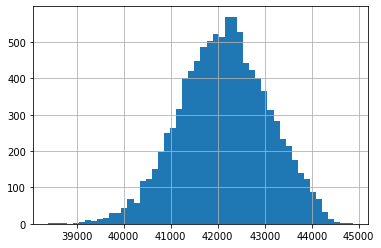

In [20]:
total_vals_2.hist(bins=50)

In [21]:
total_vals_2.describe()

count    10000.000000
mean     42131.331962
std        939.986108
min      38397.790442
25%      41494.535067
50%      42150.499323
75%      42784.341020
max      44870.898325
dtype: float64